# Ringkasan Berita


Ringkasan berita digunakan untuk mempermudah ketika ingin mengetahui isi berita secara jelas dan ringkas


## Proses Pembersihan Teks


### Import Library


In [1]:
# Library untuk text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Library untuk data manipulation
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Library untuk text similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 

### Load Data


In [2]:
data = pd.read_csv('data-artikel-cnbc.csv')
data.head()

,judul,tanggal,isi,url,kategori
0,Bukan Kaleng-kaleng! Nilai Skuad Timnas Indone...,09 September 2024 19:30,"Jakarta, CNBC Indonesia -Kedatangan pemain-pem...",https://www.cnbcindonesia.com/research/2024090...,Research
1,"Aset Bank Mandiri Tembus Rp 2.200 T, Paling Ju...",09 September 2024 19:05,"Jakarta, CNBC Indonesia -Sepanjang paruh perta...",https://www.cnbcindonesia.com/research/2024090...,Research
2,Emas Meredup Saat Suku Bunga The Fed Mau Turun...,09 September 2024 18:10,"Jakarta,CNBC Indonesia -Harga emas dunia melem...",https://www.cnbcindonesia.com/research/2024090...,Research
3,"Tetangga RI Dihantam 'Bencana' Iklim, Harga Ba...",09 September 2024 15:55,"Jakarta, CNBC Indonesia -Indeks Harga Konsumen...",https://www.cnbcindonesia.com/research/2024090...,Research
4,"Tantama Hingga Perwira, Ini Urutan Lengkap Pan...",09 September 2024 14:35,"Jakarta, CNBC Indonesia-Tentara Nasional Indon...",https://www.cnbcindonesia.com/research/2024090...,Research


In [3]:
# Filter data untuk kategori "Research" dan "News" masing-masing diambil 50 berita
research = data[data["kategori"] == "Research"].sample(n=50, random_state=42)
news = data[data["kategori"] == "News"].sample(n=50, random_state=42)

In [4]:
# Gabungkan keduanya
data = pd.concat([research, news], ignore_index=True)

### Preprocessing Text


In [5]:
def clean_text(text):
	text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Menghapus https* and www*
	text = re.sub(r'@[^\s]+', ' ', text) # Menghapus username
	text = re.sub(r'[\s]+', ' ', text) # Menghapus tambahan spasi
	text = re.sub(r'#([^\s]+)', ' ', text) # Menghapus hashtags
	text = re.sub(r"[^a-zA-Z :\.]", "", text) # Menghapus tanda baca
	text = re.sub(r'\d', ' ', text) # Menghapus angka
	text = text.lower()
	text = text.encode('ascii','ignore').decode('utf-8') #Menghapus ASCII dan unicode
	text = re.sub(r'[^\x00-\x7f]',r'', text)
	text = text.replace('\n','') #Menghapus baris baru
	text = text.strip()
	return text

def clean_stopword(tokens):
	listStopword =  set(stopwords.words('indonesian'))
	filtered_words = [word for word in tokens if word.lower() not in listStopword]
	return filtered_words

In [6]:
def preprocess_text(content):
	result = {}
	for i, text in enumerate(tqdm(content)):
		cleaned_text = clean_text(text)
		tokens = word_tokenize(cleaned_text)
		cleaned_stopword = clean_stopword(tokens)
		result[i] = ' '.join(cleaned_stopword)
	return result

prep_result = preprocess_text(data['isi'])

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 173.09it/s]


Membersihkan text dari tanda baca yang ada, kemudian menyesuaikan text agar bisa diolah lebih lanjut.


#### Hasil Preprocessing


In [7]:
print(prep_result[4])

jakarta cnbc indonesia ajaran resmi gereja katolik struktur hierarkis terpisahkan kehidupan misinya . kristus mengutus rasul menyebarkan injil misi zaman . konsili vatikan ii uskup menggantikan rasul gembala gereja . gereja dikenal berkembang kelompok pengikut yesus gereja rasul . struktur terbentuk periode kebangkitan yesus kemartiran st. ignatius antiokhia abad . hierarki gereja katolik paus pemimpin tertinggi uskup imam diakon . paus meneruskan santo petrus pemimpin uskup uskup roma memiliki peran pemimpin gereja universal . dilansir imankatolik.or.id tradisi katolik roma dipandang pusat gereja paus dipilih kardinal penasihat paus . uskup menggantikan rasul berperan pemimpin umat wilayah masingmasing bersamasama membentuk dewan uskup . peran uskup memimpin komunitas lokal . pemimpin spiritual bertanggung mempersatukan umat tugas utama : pewartaan injil perayaan sakramen pelayanan umat . mendukung tugas uskup dibantu imam diakon . imam berperan perpanjangan tangan uskup melayani jema

### Memisahkan Kalimat Berita


In [8]:
kalimat_preprocessing = nltk.sent_tokenize(prep_result[4])
kalimat = nltk.sent_tokenize(data['isi'][4])

Memisahkan kalimat pada berita yang diakhiri dengan titik, untuk setiap kalimat


## TF-IDF Konnsep

Metode  Term  Frequency-Inverse Document Frequency (TF-IDF) adalah salah satu  teknik  representasi  teks yang mengonversi kata-kata menjadi  nilai  numerik  berdasarkan  seberapa  sering kata tersebut  muncul  dalam  teks  serta  seberapa  umumnya kata tersebut  dalam  kumpulan  dokumen yang tersedia. Bobot  numerik yang dihasilkan oleh metode  ini  sering  disebut  sebagai  bobot TF-IDF.

### TF

**Term Frequency**: Dalam  dokumen d, frekuensi  merepresentasikan  jumlah  kemunculan kata t. Oleh karena  itu, kita  dapat  melihat  bahwa  frekuensi  menjadi  lebih  relevan  ketika  sebuah kata muncul di dalam  teks, yang mana hal  ini  rasional. Karena urutan  istilah  tidak  signifikan, kita  dapat  menggunakan  vektor  untuk  menggambarkan  teks  dalam  kantong model istilah. Untuk  setiap  istilah  tertentu  dalam  teks, ada  sebuah  entri  dengan  nilai yang merupakan  frekuensi  istilah. Bobot  sebuah  istilah yang muncul  dalam  sebuah  dokumen  secara  sederhana  sebanding  dengan  frekuensi  istilah  tersebut


$$
    tf(t, d) = \frac{\text{jumalah } t \text{ dalam } d}{\text{jumlah kata dalam } d}
$$



**Dokument Frequency**: mengukur  seberapa  umumnya  suatu kata terjadi di seluruh  koleksi  dokumen. Konsep  ini  mirip  dengan Term Frequency (TF), namun  perbedaannya  terletak pada bagaimana  kita  menghitung  kemunculan  suatu kata. Di TF, kita  melihat  seberapa  sering kata muncul  dalam  satu  dokumen  tertentu, sedangkan di DF, kita  melihat  berapa  banyak  dokumen yang mengandung kata tersebut di dalam  keseluruhan  koleksi  dokumen. Jadi, Document Frequency (DF) adalah  jumlah  dokumen yang memuat  suatu kata.

$$
    df(t) = \text{kemunculan } t \text{ dalam } dokumen
$$


### IDF

**Inverse Document Frequency (IDF)**: mengevaluasi tingkat relevansi suatu kata dalam konteks pencarian. Ketika mencari informasi, tujuan utama adalah menemukan dokumen yang paling sesuai dengan permintaan pengguna. Mengingat bahwa Term Frequency (TF) memperlakukan semua kata dengan nilai yang sama, frekuensi kata itu sendiri tidak cukup untuk menilai  bobot istilah dalam sebuah dokumen. IDF pertama-tama mencari frekuensi kemunculan dokumen untuk suatu kata dengan menghitung jumlah dokumen yang mengandung kata tersebut.

$$
    df(t) = N(t)
$$

$$
    df(t) = \text{Frekuensi dokumen dari suatu istilah t}
$$

$$
    N(t) = \text{Jumlah } dokumen \text{ yang mengandung istilah } t
$$

### TF-IDF

Term Frequency adalah jumlah kemunculan suatu term dalam satu dokumen saja, sedangkan Document Frequency adalah jumlah dokumen terpisah tempat istilah tersebut muncul. Namun, frekuensi ini bergantung pada seluruh korpus. IDF merupakan jumlah dokumen dalam korpus yang dipisahkan oleh frekuensi teks. Dengan kata lain, IDF mengukur seberapa umum atau langka suatu kata dalam seluruh koleksi dokumen.

$$
    idf(t) = \frac{N}{df(t)}=\frac{N}{N(t)}
$$

$$
    idf(t) = log_2 \frac{N}{df(t)}
$$

Maka dari itu rumus dari TF * IDF adalah sebagai berikut:

$$
    tf-idf(t, d) = tf(t, d) * idf(t)
$$
$$W_{d,t} = tf_{t,d} \cdot idf_{t,d}$$
Keterangan:

$W_{d,t}$ = Nilai _Term Frequency_ untuk _term_ (t) dalam dokumen (d).<br>
$tf_{t,d}$ = Frekuensi kemunculan _term_ (t) dalam dokumen (d).<br>
$idf_{t,d}$ = Inverse Document Frequency Nilai kebalikan frekuensi dokumen _term_ (t) dalam dokumen (d).


### Contoh Kalimat:
1. **Kalimat 1**: "Saya suka teori graf, karena teori graf seru." (8 kata)
2. **Kalimat 2**: "Teori graf digunakan untuk memecahkan masalah." (6 kata)
3. **Kalimat 3**: "Saya suka belajar dan memecahkan masalah." (6 kata)

#### Langkah 1: Hitung TF (Term Frequency)

| Kata        | Kalimat 1 (TF)  | Kalimat 2 (TF)  | Kalimat 3 (TF)  |
|-------------|-----------------|-----------------|-----------------|
| saya        | 1/8             | 0               | 1/6             |
| suka        | 1/8             | 0               | 1/6             |
| teori       | 2/8             | 1/6             | 0               |
| graf        | 2/8             | 1/6             | 0               |
| karena      | 1/8             | 0               | 0               |
| seru        | 1/8             | 0               | 0               |
| digunakan   | 0               | 1/6             | 0               |
| untuk       | 0               | 1/6             | 0               |
| memecahkan  | 0               | 1/6             | 1/6             |
| masalah     | 0               | 1/6             | 1/6             |
| belajar     | 0               | 0               | 1/6             |
| dan         | 0               | 0               | 1/6             |

Kata "teori" dan "graf" muncul **dua kali** di **Kalimat 1**, maka TF untuk kedua kata ini di Kalimat 1 adalah \(2/8\), sedangkan untuk kata lainnya dihitung sesuai jumlah kata dalam masing-masing kalimat.

#### Langkah 2: Hitung IDF (Inverse Document Frequency)

| Kata        | df (jumlah dokumen yang mengandung kata) | IDF                  |
|-------------|------------------------------------------|----------------------|
| saya        | 2                                        | (log(3/2)) = 0.18 |
| suka        | 2                                        | (log(3/2)) = 0.18 |
| teori       | 2                                        | (log(3/2)) = 0.18 |
| graf        | 2                                        | (log(3/2)) = 0.18 |
| karena      | 1                                        | (log(3/1)) = 0.48 |
| seru        | 1                                        | (log(3/1)) = 0.48 |
| digunakan   | 1                                        | (log(3/1)) = 0.48 |
| untuk       | 1                                        | (log(3/1)) = 0.48 |
| memecahkan  | 2                                        | (log(3/2)) = 0.18 |
| masalah     | 2                                        | (log(3/2)) = 0.18 |
| belajar     | 1                                        | (log(3/1)) = 0.48 |
| dan         | 1                                        | (log(3/1)) = 0.48 |

#### Langkah 3: Hitung TF-IDF

Untuk setiap kata di setiap kalimat, kita hitung TF-IDF:
- **TF-IDF** = TF × IDF

Sebagai contoh, untuk kata **"teori"** di Kalimat 1:
$$
\text{TF-IDF}_{\text{"teori"}} = (2/8) \times 0.18 = 0.045
$$
Contoh TF-IDF lain:
- **"saya"** di Kalimat 1: \( (1/8) \times 0.18 = 0.0225 \)
- **"suka"** di Kalimat 3: \( (1/6) \times 0.18 = 0.03 \)

Demikian juga, perhitungan TF-IDF dilakukan untuk setiap kata di setiap kalimat.

TF-IDF setiap kalimat, untuk menghitung term yang ada pada setiap kalimatnya.


In [9]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_preprocessing = tfidf_vectorizer.fit_transform(kalimat_preprocessing)

terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_preprocessing.toarray(), columns=terms)

tfidf_preprocessing

,abad,ajaran,antiokhia,apostolik,batu,berabadabad,berfungsi,berkembang,berkesinambungan,berperan,...,umat,universal,uskup,utama,vatikan,wafat,warisan,wilayah,yesus,zaman
0,0.000000,0.323319,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406573
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.217747,0.000000,0.417296,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.413249,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307033,0.000000
4,0.335399,0.000000,0.335399,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.249192,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.252610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.336438,0.351109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.266608,...,0.266608,0.000000,0.345389,0.000000,0.000000,0.000000,0.000000,0.330957,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.283187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Cosine Similarity


Cosine similarity digunakan untuk mengukur seberapa mirip dua vektor dalam ruang berdimensi banyak. Hasil dari cosine similarity ini akan menentukan apakah vektor tersebut menuju ke arah yang sama. Semakin kecil sudut antara dua vektor, maka semakin mirip satu sama lain sedangkan begitu juga sebaliknya, semakin besar nilai cosine similarity maka vektor tersebut dianggap jauh kemiripannya. Dalam ringkasan dokumen ini penting untuk menghitung nilai cosine similarity untuk mengetahui hubungan kesamaan antara kalimat satu dengan kalimat lainnya. Vektor yang digunakan untuk menghitung nilai cosine simmilarity ini adalah hasil dari TF-IDF pada langkah sebelumnya.


$$simmilarity(A, B) = \frac{A \cdot B}{|A||B|}$$


Keterangan:

$A.B$ = Vector dot product dari A dan B dihitung dengan $\sum_{i=1}^n x_{k}y_{k}$

$|A|$ = Panjang vektor A dihitung dengan $\sum_{i=1}^n x_{k}^2$ = $\sqrt{\mathrm{a}_{1}^{2} + \mathrm{a}_{2}^{2} + \mathrm{a}_{3}^{2}} +...+ \mathrm{n}_{n}^{2}$

$|B|$ = Panjang vektor B dihitung dengan $\sum_{i=1}^n y_{k}^2$ = $\sqrt{\mathrm{b}_{1}^{2} + \mathrm{b}_{2}^{2} + \mathrm{b}_{3}^{2}} + ...+ \mathrm{n}_{n}^{2}$


### Contoh Kalimat:
1. **Kalimat 1**: "Saya suka teori graf, karena teori graf seru."
2. **Kalimat 2**: "Teori graf digunakan untuk memecahkan masalah."
3. **Kalimat 3**: "Saya suka belajar dan memecahkan masalah."

#### Langkah 1: Hitung TF-IDF untuk Setiap Kalimat
Anggap hasil tf idf sudah diketahui

| Kata        | Kalimat 1 (TF-IDF) | Kalimat 2 (TF-IDF) | Kalimat 3 (TF-IDF) |
|-------------|---------------------|---------------------|---------------------|
| saya        | 0.0225              | 0                   | 0.03                |
| suka        | 0.0225              | 0                   | 0.03                |
| teori       | 0.045               | 0.03                | 0                   |
| graf        | 0.045               | 0.03                | 0                   |
| karena      | 0.06                | 0                   | 0                   |
| seru        | 0.06                | 0                   | 0                   |
| digunakan   | 0                   | 0.08                | 0                   |
| untuk       | 0                   | 0.08                | 0                   |
| memecahkan  | 0                   | 0.03                | 0.03                |
| masalah     | 0                   | 0.03                | 0.03                |
| belajar     | 0                   | 0                   | 0.08                |
| dan         | 0                   | 0                   | 0.08                |

#### Langkah 2: Hitung Cosine Similarity antara Dua Kalimat
Cosine similarity antara dua kalimat \( A \) dan \( B \) dapat dihitung dengan rumus:
$$
\text{Cosine Similarity}(A, B) = \frac{A \cdot B}{||A|| \times ||B||}
$$
di mana \( A dot B \) adalah **dot product** dari vektor TF-IDF, dan \( ||A|| \) dan \( ||B|| \) adalah **panjang vektor** untuk kalimat \( A \) dan \( B \).

perhitungan **Cosine Similarity** antara **Kalimat 1** dan **Kalimat 2** sebagai contoh.

1. **Dot Product** \( A dot B \):
$$
A \cdot B = (0.045 \times 0.03) + (0.045 \times 0.03) = 0.00135 + 0.00135 = 0.0027
$$
Catatan: Hanya kata "teori" dan "graf" yang muncul di kedua kalimat, sehingga hanya mereka yang diperhitungkan.

2. **Norm (Panjang Vektor)** untuk **Kalimat 1**:
$$
||A|| = \sqrt{(0.0225)^2 + (0.0225)^2 + (0.045)^2 + (0.045)^2 + (0.06)^2 + (0.06)^2}
$$
$$
||A|| = \sqrt{0.00050625 + 0.00050625 + 0.002025 + 0.002025 + 0.0036 + 0.0036} = \sqrt{0.0122625} \approx 0.1108
$$

3. **Norm (Panjang Vektor)** untuk **Kalimat 2**:
$$
||B|| = \sqrt{(0.03)^2 + (0.03)^2 + (0.08)^2 + (0.08)^2 + (0.03)^2 + (0.03)^2}
$$
$$
||B|| = \sqrt{0.0009 + 0.0009 + 0.0064 + 0.0064 + 0.0009 + 0.0009} = \sqrt{0.0164} \approx 0.1281
$$

4. **Cosine Similarity**:
$$
\text{Cosine Similarity}(A, B) = \frac{0.0027}{0.1108 \times 0.1281} = \frac{0.0027}{0.01419} \approx 0.1902
$$

### Kesimpulan
Cosine similarity antara **Kalimat 1** dan **Kalimat 2** adalah sekitar **0.1902**, yang menunjukkan bahwa kedua kalimat memiliki kesamaan moderat berdasarkan konten yang dibagikan (kata "teori" dan "graf").

In [10]:
cossim_prep = cosine_similarity(tfidf_preprocessing, tfidf_preprocessing)

similarity_matrix = pd.DataFrame(cossim_prep, 
								 index=range(len(kalimat_preprocessing)), 
								 columns=range(len(kalimat_preprocessing)))

similarity_matrix

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.000000,0.027828,0.055116,0.059860,0.090742,0.022436,0.055648,0.000000,0.000000,...,0.078032,0.097742,0.000000,0.030672,0.120806,0.000000,0.000000,0.122676,0.120145,0.250251
1,0.000000,1.000000,0.081205,0.080417,0.000000,0.000000,0.000000,0.000000,0.064403,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145743,0.000000,0.000000
2,0.027828,0.081205,1.000000,0.153675,0.000000,0.096673,0.105410,0.025553,0.249787,0.061663,...,0.035831,0.104130,0.040994,0.039588,0.000000,0.000000,0.000000,0.105454,0.065566,0.000000
3,0.055116,0.080417,0.153675,1.000000,0.076510,0.082527,0.057353,0.050609,0.065461,0.000000,...,0.070967,0.088893,0.000000,0.078407,0.000000,0.000000,0.000000,0.152772,0.055972,0.000000
4,0.059860,0.000000,0.000000,0.076510,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085937,0.052502,0.060790,0.000000
5,0.090742,0.000000,0.096673,0.082527,0.000000,1.000000,0.327206,0.169813,0.163934,0.071536,...,0.288729,0.430394,0.152670,0.112925,0.000000,0.000000,0.000000,0.183684,0.183258,0.000000
6,0.022436,0.000000,0.105410,0.057353,0.000000,0.327206,1.000000,0.159163,0.227856,0.200219,...,0.148345,0.281352,0.139150,0.078478,0.125708,0.000000,0.000000,0.039356,0.116178,0.000000
7,0.055648,0.000000,0.025553,0.050609,0.000000,0.169813,0.159163,1.000000,0.000000,0.000000,...,0.146027,0.248036,0.258113,0.217592,0.071908,0.094538,0.040739,0.066172,0.191738,0.000000
8,0.000000,0.064403,0.249787,0.065461,0.000000,0.163934,0.227856,0.000000,1.000000,0.097810,...,0.000000,0.093979,0.065025,0.098783,0.000000,0.000000,0.000000,0.105824,0.059175,0.000000
9,0.000000,0.000000,0.061663,0.000000,0.000000,0.071536,0.200219,0.000000,0.097810,1.000000,...,0.000000,0.233272,0.053314,0.000000,0.000000,0.000000,0.000000,0.000000,0.188482,0.000000


## Graph

Hasil dari nilai _Cosine Simmilarity_ ini akan dapat digunakan untuk membentuk graph dengan menggunakan modul nx.graph. Graph ini akan menggambarkan ilustrasi dari kedekatan setiap kalimatnya dalam berita tersebut. Dalam proses penggambaran graph tersebut diperlukan ambang batas _(threshold)_ yang digunakan untuk memberikan batasan agar keseluruhan kalimatnya tidak dihubungkan menggunakan garis _(edge)_. Nilai ambang batas _(threshold)_ yang digunakan adalah **0.1**


In [11]:
# threshold = 0.5
# adjacency_matrix = (similarity_matrix > threshold).astype(int)
# adjacency_matrix

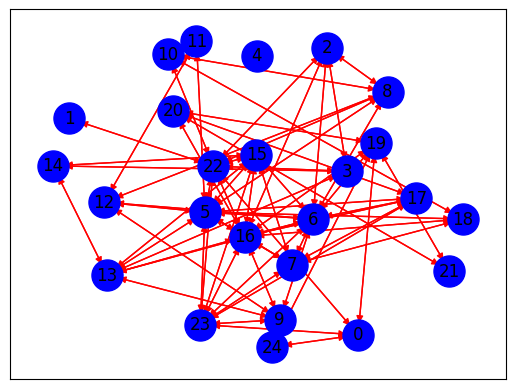

In [12]:
G_preprocessing = nx.DiGraph()
for i in range(len(cossim_prep)):
    G_preprocessing.add_node(i)

for i in range(len(cossim_prep)):
    for j in range(len(cossim_prep)):
        similarity_preprocessing = cossim_prep[i][j]
        if similarity_preprocessing > 0.1 and i != j:
            G_preprocessing.add_edge(i, j)

pos = nx.spring_layout(G_preprocessing, k=2)
nx.draw_networkx_nodes(G_preprocessing, pos, node_size=500, node_color='b')
nx.draw_networkx_edges(G_preprocessing, pos, edge_color='red', arrows=True)
nx.draw_networkx_labels(G_preprocessing, pos)

plt.show()

## Matrix Centralitas


Matriks Sentralitas adalah matriks yang digunakan untuk merepresentasikan ukuran sentralitas dari setiap node dalam jaringan. Sentralitas adalah konsep dalam analisis jaringan yang mencoba mengukur sejauh mana suatu node berada di pusat jaringan atau sejauh mana suatu node penting dalam graph.


### Closeness Centrality

Closeness similarity adalah ukuran sejauh mana nilai kedekatan antara pasangan node dalam suatu jaringan serupa. Dengan ini kita dapat mengukur kesamaan struktural antara node-node dalam graf berdasarkan nilai kedekatan mereka.

$$CC(i) = \frac{N-1}{\sum_{j}d(i, j)}$$

Keterangan:

$N$ = nomor dari masing-masing node<br>
$d(i, j)$ = $d$ adalah panjang jalur terpendek antara node $i$ dan $j$ dalam jaringan<br>
$(sum_{j} d(i, j))$ = adalah total jarak terpendek dari simpul \(i\) ke semua simpul \(j\).


### Contoh Manual Perhitungan Closeness Centrality

Misalkan kita memiliki graf sederhana berikut:

```bash
A --- B --- C
|     |
D     E
```

Graf ini terdiri dari 5 simpul: \(A, B, C, D, E\). Kita akan menghitung closeness centrality untuk simpul \(A\).


#### Langkah 1: Identifikasi Jarak Terpendek (Shortest Path)
Dari simpul \(A\), jarak terpendek ke setiap simpul lain adalah sebagai berikut:

- \(d(A, A) = 0\) (karena ke diri sendiri jaraknya 0).
- \(d(A, B) = 1\) (langsung terhubung).
- \(d(A, C) = 2\) (melalui simpul \(B\)).
- \(d(A, D) = 1\) (langsung terhubung).
- \(d(A, E) = 2\) (melalui simpul \(B\)).

#### Langkah 2: Hitung Total Jarak
Lalu jumlahkan jarak dari simpul \(A\) ke semua simpul lainnya:

$$
\sum_{j} d(A, j) = d(A, B) + d(A, C) + d(A, D) + d(A, E) = 1 + 2 + 1 + 2 = 6
$$


#### Langkah 3: Hitung Closeness Centrality \(CC(A)\)
Jumlah simpul \(N = 5\). Maka, closeness centrality untuk simpul \(A\) adalah:

$$
CC(A) = \frac{N-1}{\sum_{j} d(A, j)} = \frac{5-1}{6} = \frac{4}{6} = 0.6667
$$

### Interpretasi
- Closeness centrality \(CC(A) = 0.6667\) menunjukkan bahwa simpul \(A\) relatif "dekat" dengan simpul-simpul lain dalam graf. Nilai ini menunjukkan bahwa rata-rata jarak dari \(A\) ke semua simpul lain tidak terlalu jauh.

Jika kita melakukan perhitungan untuk simpul lain, simpul yang memiliki total jarak terendah ke simpul-simpul lain akan memiliki closeness centrality tertinggi.

#### Closeness Centrality Implementasi Kode


In [13]:
closeness_preprocessing = nx.closeness_centrality(G_preprocessing)

sorted_closeness_preprocessing = sorted(closeness_preprocessing.items(), key=lambda x: x[1], reverse=True)
print("Closeness Centrality:")
for node, closeness in sorted_closeness_preprocessing:
    print(f"Node {node}: {closeness:.4f}")

Closeness Centrality:
Node 16: 0.6679
Node 6: 0.6298
Node 5: 0.6123
Node 22: 0.5957
Node 23: 0.5800
Node 15: 0.5510
Node 7: 0.5126
Node 2: 0.5009
Node 8: 0.5009
Node 13: 0.5009
Node 9: 0.4898
Node 17: 0.4898
Node 19: 0.4898
Node 0: 0.4690
Node 12: 0.4592
Node 18: 0.4592
Node 20: 0.4498
Node 10: 0.4322
Node 3: 0.4239
Node 11: 0.4082
Node 14: 0.3867
Node 1: 0.3736
Node 24: 0.3613
Node 21: 0.3391
Node 4: 0.0000


### Ringkasan Berita


In [14]:
ringkasan_closeness_preprocessing = ""
print("Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:")
for node, closeness_preprocessing in sorted_closeness_preprocessing[:3]:
    top_sentence = kalimat[node]
    ringkasan_closeness_preprocessing += top_sentence + " "
    print(f"Node {node}: Closeness Centrality = {closeness_preprocessing:.4f}")
    print(f"Kalimat: {top_sentence}\n")

Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:
Node 16: Closeness Centrality = 0.6679
Kalimat: Selain Paus dan uskup, kardinal juga memainkan peran penting dalam hierarki Gereja Katolik.

Node 6: Closeness Centrality = 0.6298
Kalimat: Paus, yang meneruskan Santo Petrus sebagai pemimpin para uskup, adalah uskup Roma dan juga memiliki peran sebagai pemimpin Gereja universal.

Node 5: Closeness Centrality = 0.6123
Kalimat: Hierarki Gereja Katolik terdiri dari Paus sebagai pemimpin tertinggi, para uskup, imam, dan diakon.



### Page Rank


Dalam konteks ini, dokumen dianggap sebagai “halaman” yang terhubung oleh hubungan yang merefleksikan keterkaitan atau relevansinya. Dengan menerapkan konsep PageRank, dokumen yang dianggap lebih “penting” atau relevan dapat diberikan skor lebih tinggi. Penggunaan faktor damping, serupa dengan dalam algoritma PageRank, dapat membantu mengontrol sejauh mana pengaruh satu dokumen terhadap yang lain. Dengan memberikan skor pada dokumen berdasarkan hubungan mereka dalam jaringan informasi, kita dapat menghasilkan ringkasan yang mencerminkan tingkat relevansi dan pentingnya masing-masing dokumen dalam konteks keseluruhan.

$$PR_i = \frac{1-d}{n} + d \sum_{P_j\in\{1 \dots,n\}} \frac{PR_i}{L_j}$$

Keterangan:

$PR(i)$ = adalah PageRank dari halaman web ke i.<br>
$d$ = adalah faktor redaman, biasanya diatur sebesar 0,85, yang digunakan untuk menghitung probabilitas bahwa peramban acak akan “melompat” ke halaman acak dan tidak mengikuti sebuah link.<br>
$PR(i)$ = adalah PageRank halaman ke i, yaitu halaman yang memiliki sambungan yang mengarah ke halaman i.<br>
$L(c)$ = adalah jumlah hubungan keluar pada halaman j.


In [15]:
pagerank_preprocessing = nx.pagerank(G_preprocessing)

sorted_pagerank_preprocessing= sorted(pagerank_preprocessing.items(), key=lambda x: x[1], reverse=True)
print("Page Rank :")
for node, pagerank_preprocessing in sorted_pagerank_preprocessing:
    print(f"Node {node}: {pagerank_preprocessing:.4f}")

Page Rank :
Node 16: 0.0822
Node 5: 0.0755
Node 6: 0.0751
Node 22: 0.0701
Node 23: 0.0576
Node 15: 0.0516
Node 19: 0.0477
Node 13: 0.0468
Node 7: 0.0450
Node 8: 0.0414
Node 17: 0.0401
Node 12: 0.0354
Node 2: 0.0352
Node 9: 0.0340
Node 0: 0.0329
Node 20: 0.0325
Node 10: 0.0311
Node 3: 0.0306
Node 18: 0.0290
Node 11: 0.0242
Node 14: 0.0239
Node 24: 0.0200
Node 21: 0.0199
Node 1: 0.0122
Node 4: 0.0062


#### Hasil Ringkasan


In [16]:
ringkasan_pagerank_preprocessing = ""
print("Tiga Node Tertinggi Page Rank Menggunakan Preprocessing:")
for node, pagerank_preprocessing in sorted_pagerank_preprocessing[:3]:
    top_sentence = kalimat[node]
    ringkasan_pagerank_preprocessing += top_sentence + " "
    print(f"Node {node}: Page Rank = {pagerank_preprocessing:.4f}")
    print(f"Kalimat: {top_sentence}\n")

Tiga Node Tertinggi Page Rank Menggunakan Preprocessing:
Node 16: Page Rank = 0.0822
Kalimat: Selain Paus dan uskup, kardinal juga memainkan peran penting dalam hierarki Gereja Katolik.

Node 5: Page Rank = 0.0755
Kalimat: Hierarki Gereja Katolik terdiri dari Paus sebagai pemimpin tertinggi, para uskup, imam, dan diakon.

Node 6: Page Rank = 0.0751
Kalimat: Paus, yang meneruskan Santo Petrus sebagai pemimpin para uskup, adalah uskup Roma dan juga memiliki peran sebagai pemimpin Gereja universal.

